# Clustering using LSH
> **Documentation:** [Locality Sensitive Hasing](https://spark.apache.org/docs/2.2.0/ml-features.html#locality-sensitive-hashing)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/30 23:15:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/30 23:15:21 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-plantclef-2024"
! date
! gcloud storage ls {root}/data/parquet_files

Sat Mar 30 23:15:24 UTC 2024
gs://dsgt-clef-plantclef-2024/data/parquet_files/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_1/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_4/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training_cropped_resized/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training_cropped_resized_v2/


In [4]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/parquet_files/"
train = "PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the Train parquet file
train_gcs_path = f"{gcs_path}{train}"

# Read the Parquet file into a DataFrame
train_df = spark.read.parquet(train_gcs_path)

# Show the data (for example, first few rows)
train_df.show(n=3)

+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+--------------------+
|          image_name|                path| organ|species_id|    obs_id|             license|partner|              author|altitude|     latitude|    longitude|gbif_species_id|             species|     genus|       family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|                data|
+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+-----------

In [5]:
# Select columns
cols = ["image_name", "latitude", "longitude", "species", "species_id"]
local_df = train_df.select(cols).cache()
local_df.show(n=3)

+--------------------+-------------+-------------+--------------------+----------+
|          image_name|     latitude|    longitude|             species|species_id|
+--------------------+-------------+-------------+--------------------+----------+
|2fb34c40832bffad3...|         NULL|         NULL|Posidonia oceanic...|   1361703|
|38da078be8660b772...|     43.59753|     -8.12915|Arctotheca calend...|   1355927|
|4fe98ed9eff6eed40...|38.6945228605|-9.2953275237|Podranea ricasoli...|   1388692|
+--------------------+-------------+-------------+--------------------+----------+
only showing top 3 rows



In [6]:
from pyspark.sql import functions as F


def count_latitude_longitude_rows(df, verbose=True):
    # Count rows where 'latitude' and 'longitude' is NULL
    lat_null_count = df.filter(F.col("latitude").isNull()).count()
    long_null_count = df.filter(F.col("longitude").isNull()).count()

    # Count rows where either 'latitude' or 'longitude' is NULL
    null_lat_long_count = df.filter(
        F.col("latitude").isNull() | F.col("longitude").isNull()
    ).count()

    if verbose:
        print(f"Latitude NULL count: {lat_null_count}")
        print(f"Longitude NULL count: {long_null_count}")
        print(f"Rows with NULL latitude or longitude: {null_lat_long_count}")


# Print results
count_latitude_longitude_rows(df=local_df)

Latitude NULL count: 702608
Longitude NULL count: 702592
Rows with NULL latitude or longitude: 702609


In [7]:
# Filter rows where 'species' is not NULL and count distinct species
distinct_species_count = (
    train_df.where(F.col("latitude").isNotNull() & F.col("longitude").isNotNull())
    .select(F.col("species"))
    .distinct()
    .count()
)

total_species_count = train_df.select(F.col("species")).distinct().count()

# Print
print(f"Total number of species: {total_species_count}")
print(f"Number of distinct species with non-NULL values: {distinct_species_count}")

Total number of species: 7855
Number of distinct species with non-NULL values: 6246


In [8]:
# Create a DataFrame to see species imbalance
species_df = (
    local_df.select(F.col("species"))
    .groupBy(F.col("species"))
    .count()
    .withColumnRenamed("count", "species_count")
    .orderBy(F.col("species_count").desc())
)

# Show DF
species_df.show(n=20)
species_df.orderBy(F.col("species_count")).show(n=20)

+--------------------+-------------+
|             species|species_count|
+--------------------+-------------+
|Styphnolobium jap...|          823|
|Frangula alnus Mill.|          793|
|Aria edulis (Will...|          770|
|Lathyrus oleraceu...|          700|
|  Bromus sterilis L.|          674|
|   Lotus hirsutus L.|          668|
|Scandosorbus inte...|          662|
|     Hedera helix L.|          653|
|Oxalis dillenii J...|          653|
|Calicotome spinos...|          642|
|Castanea sativa M...|          638|
|Buxus semperviren...|          636|
|    Arbutus unedo L.|          634|
|Pistacia lentiscu...|          632|
|   Ulmus minor Mill.|          630|
|Tecomaria capensi...|          627|
|     Quercus ilex L.|          626|
|Calamagrostis are...|          625|
|Pittosporum tobir...|          625|
|Cercis siliquastr...|          624|
+--------------------+-------------+
only showing top 20 rows



+--------------------+-------------+
|             species|species_count|
+--------------------+-------------+
|Papaver confine J...|            1|
|Genista tribracte...|            1|
|Galium valentinum...|            1|
|Delphinium bolosi...|            1|
|Festuca liviensis...|            1|
| Centaurea pinae Pau|            1|
|Poa × austrohercy...|            1|
| Crocus clusii J.Gay|            1|
|           Cardamine|            1|
|Anchusa puechii V...|            1|
|           Equisetum|            1|
|Myosotis soleirol...|            1|
|Armeria muelleri ...|            1|
|Trisetaria aurea ...|            1|
|Pilosella pilosel...|            1|
|Helianthemum papi...|            1|
|Orobanche portoil...|            1|
|Trisetaria macroc...|            1|
|             Populus|            1|
|Koeleria caudata ...|            1|
+--------------------+-------------+
only showing top 20 rows



In [9]:
# Filter data where 'latitude' and 'longitude' is not NULL
geo_local_df = local_df.where(
    F.col("latitude").isNotNull() & F.col("longitude").isNotNull()
)
sub_species_df = (
    geo_local_df.groupBy("species", "species_id")
    .agg(F.count("*").alias("n"))
    .where(F.col("n") > 100)
    .orderBy(F.rand(seed=42))
    .limit(10)
).cache()
sub_species_df.show(truncate=80)

# Sub local
sub_local_df = geo_local_df.join(
    sub_species_df.select("species_id"),
    "species_id",
)
sub_local_df.show(truncate=80)

+-------------------------------------+----------+---+
|                              species|species_id|  n|
+-------------------------------------+----------+---+
|                 Lathyrus hirsutus L.|   1363800|161|
|             Salvia rosmarinus Spenn.|   1722409|304|
|      Luzula sylvatica (Huds.) Gaudin|   1397430|254|
|                 Alchemilla alpina L.|   1397279|194|
|                  Veronica montana L.|   1359979|178|
|  Hedysarum boveanum Bunge ex Basiner|   1359231|105|
|Echinops bannaticus Rochel ex Schrad.|   1398631|146|
|         Oenanthe aquatica (L.) Poir.|   1393990|156|
|                    Rumex × acutus L.|   1737469|139|
|                Pistacia lentiscus L.|   1356290|364|
+-------------------------------------+----------+---+

+----------+--------------------------------------------+------------------+------------------+--------------------+
|species_id|                                  image_name|          latitude|         longitude|             spec

## Locality Sensitive Hashing

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import BucketedRandomProjectionLSH

# Combine latitude and longitude into a single vector column
vectorAssembler = VectorAssembler(
    inputCols=["latitude", "longitude"], outputCol="features"
)

# Standardize the features
standardScaler = StandardScaler(
    inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True
)

# Apply LSH
brpLSH = BucketedRandomProjectionLSH(
    inputCol="scaledFeatures", outputCol="hashes", bucketLength=20.0, numHashTables=5
)

# Create Pipeline
pipeline = Pipeline(stages=[vectorAssembler, standardScaler, brpLSH])

# Fit pipeline to DF
model = pipeline.fit(sub_local_df)

# Apply the model to transform the DF
transformed_df = model.transform(sub_local_df).cache()

# Show results
transformed_df.show(n=10)

+----------+--------------------+-----------------+------------------+--------------------+--------------------+--------------------+--------------------+
|species_id|          image_name|         latitude|         longitude|             species|            features|      scaledFeatures|              hashes|
+----------+--------------------+-----------------+------------------+--------------------+--------------------+--------------------+--------------------+
|   1397279|799cfaae6ee06aa6f...|      61.74781701|        9.04809128|Alchemilla alpina L.|[61.74781701,9.04...|[1.65744995107132...|[[0.0], [-1.0], [...|
|   1397279|de429917248253c3e...|    47.4581228519|     13.6214842559|Alchemilla alpina L.|[47.4581228519,13...|[0.28317921955357...|[[-1.0], [0.0], [...|
|   1397279|e8e7afdaee271cc1c...|44.19662777777778|10.714066666666666|Alchemilla alpina L.|[44.1966277777777...|[-0.0304858016683...|[[-1.0], [0.0], [...|
|   1397279|ba882a8ad8f7d8e34...|46.48377897222223| 12.04464547222222|

In [11]:
# Extract LSH from the pipeline
brpLSHModel = model.stages[-1]

# Perform an approximate similarity join with itself
threshold = 1.5
approx_sim_df = brpLSHModel.approxSimilarityJoin(
    transformed_df, transformed_df, threshold, distCol="EuclideanDistance"
)

# Show results
approx_sim_df.select(
    "datasetA.latitude", "datasetA.longitude", "datasetB.latitude", "datasetB.longitude"
).show()

+-----------------+------------------+------------------+------------------+
|         latitude|         longitude|          latitude|         longitude|
+-----------------+------------------+------------------+------------------+
|      61.74781701|        9.04809128| 50.70140695555556| 3.677347116666666|
|      61.74781701|        9.04809128|     48.8449906055|      1.0490732963|
|    47.4581228519|     13.6214842559|           42.9182|           3.04683|
|    47.4581228519|     13.6214842559|       52.03356918|       16.87214105|
|    47.4581228519|     13.6214842559|       45.43960676|        4.38249345|
|    47.4581228519|     13.6214842559|          51.74968|      0.4385466667|
|    47.4581228519|     13.6214842559|          48.92361|           2.57889|
|    47.4581228519|     13.6214842559|45.140659999722224|         1.8550822|
|    47.4581228519|     13.6214842559|     52.4144065852|     -1.5105250086|
|44.19662777777778|10.714066666666666|     43.5255617509|      6.4819707256|

In [12]:
approx_sim_df.groupBy("datasetA.image_name").agg(
    F.count("datasetB.image_name").alias("n")
).select(F.mean("n")).show()

+------------------+
|            avg(n)|
+------------------+
|1361.8905547226386|
+------------------+



In [13]:
# Avg. num of neighbors from approxSimilarityJoin to be 20 to 100
# Want enough neighbors to see local topology, but not too many
# Count of similarity join divided by original count squared
k_n = 2900000 / 2000
print(k_n)

1450.0


In [14]:
import time
import numpy as np


# Function to measure search
def approx_sim_search(transformed_df, threshold):
    data = {}
    for t in threshold:
        # Perform an approximate similarity join with itself for a threshold range
        approx_sim_df = brpLSHModel.approxSimilarityJoin(
            transformed_df, transformed_df, t, distCol="EuclideanDistance"
        )
        start = time.time()
        approx_count = approx_sim_df.count()
        end = time.time()
        run_time = end - start
        data[t] = [run_time, approx_count]
    return data


# Run function
threshold = np.arange(0.1, 1.1, 0.1)
data = approx_sim_search(transformed_df, threshold)

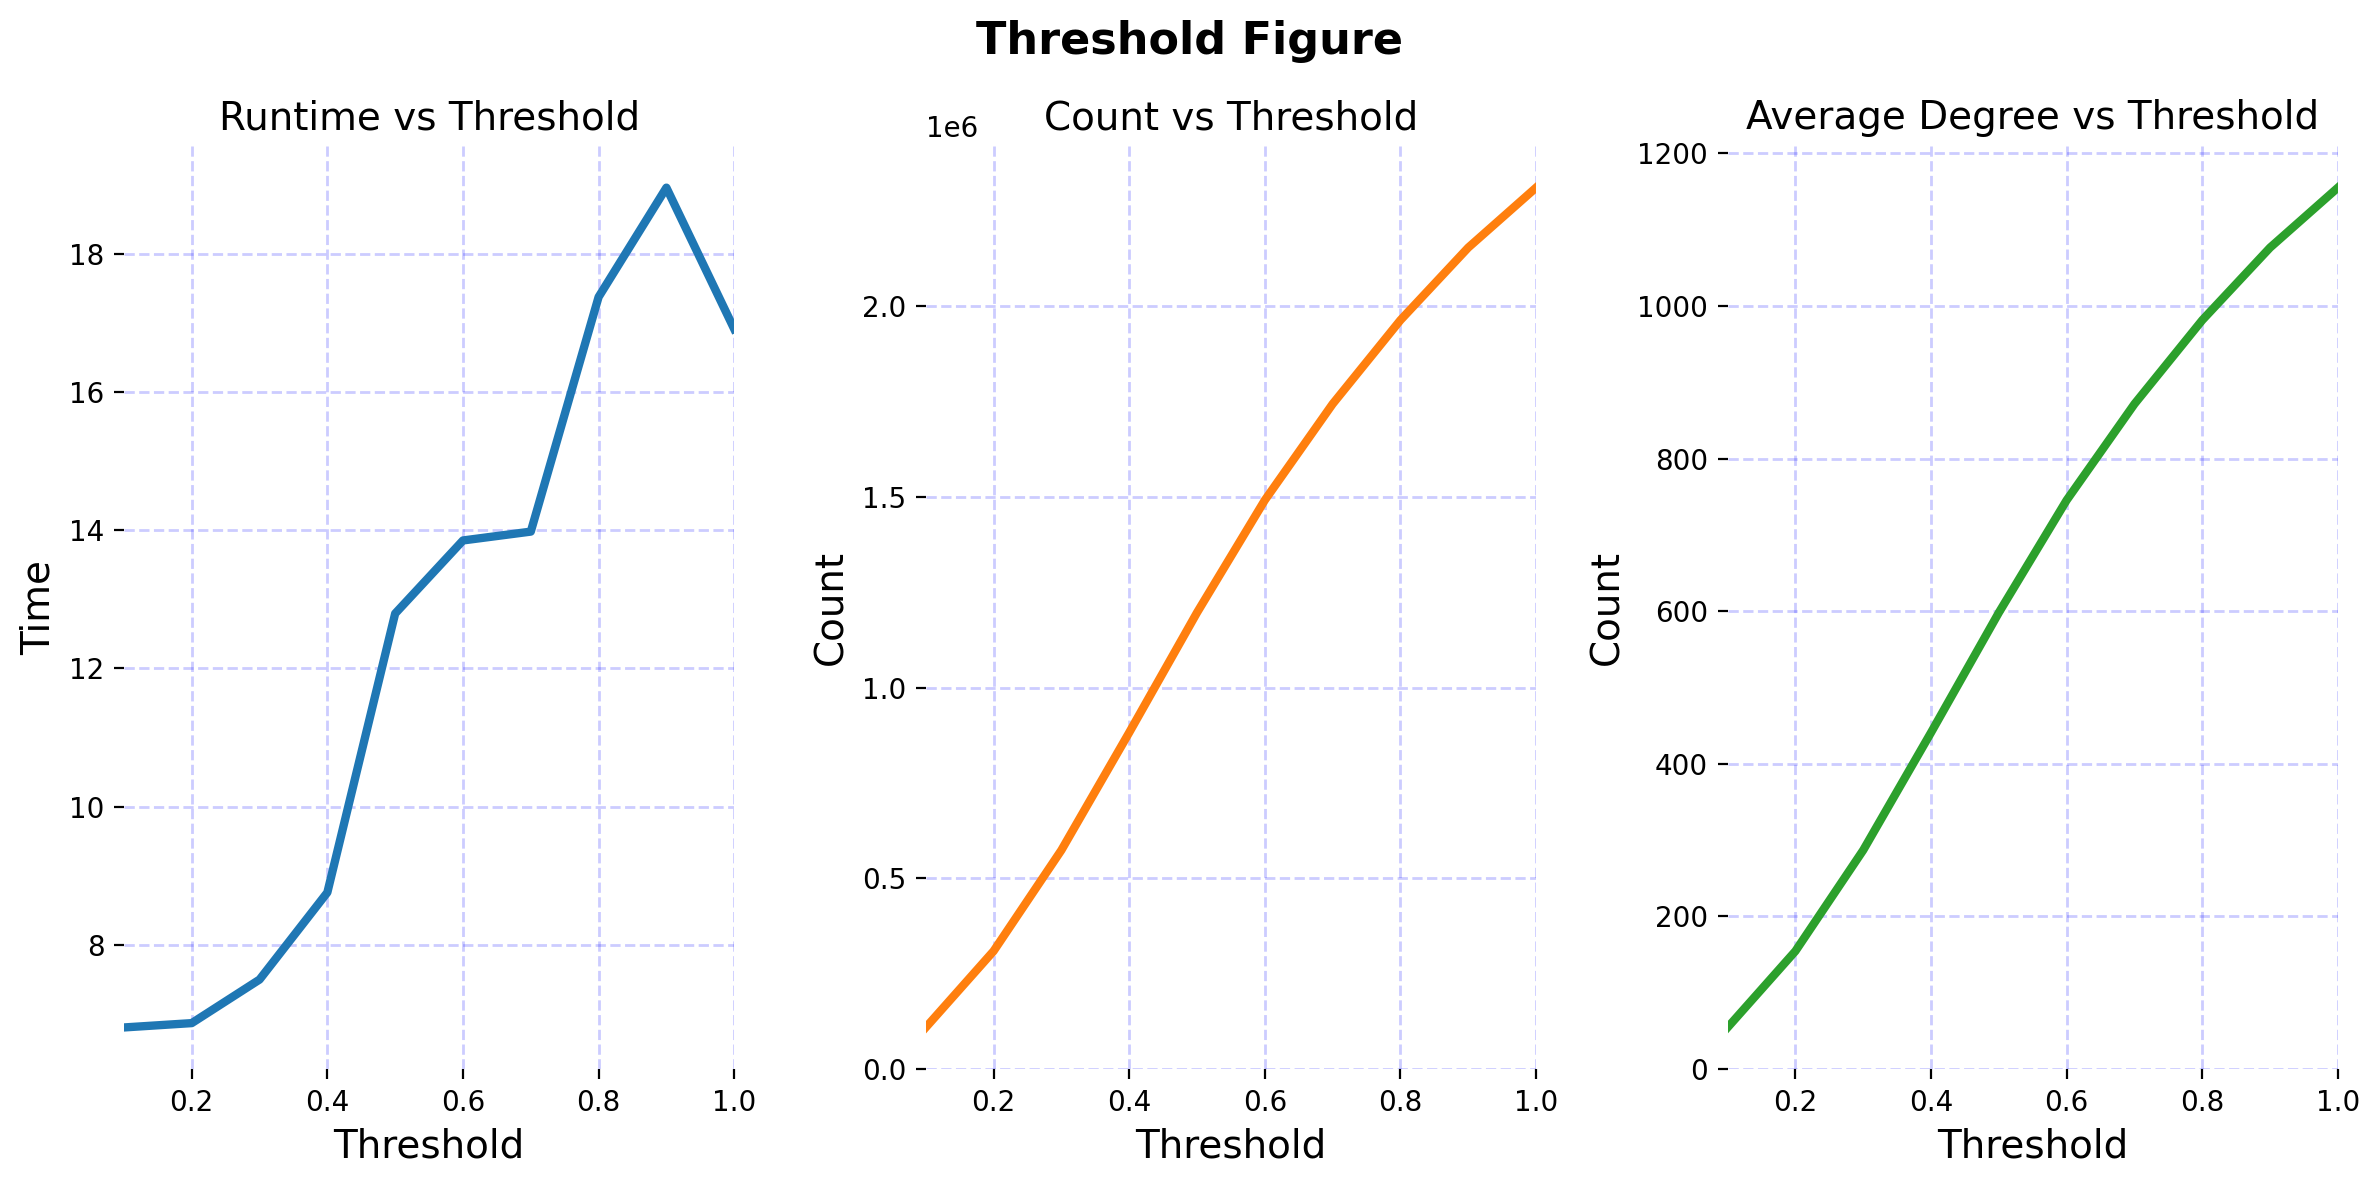

In [15]:
import matplotlib.pyplot as plt


def plot_threshold_values(data, transformed_df):
    original_count = transformed_df.count()
    thresholds = list(data.keys())
    times = [v[0] for v in data.values()]
    counts = [v[1] for v in data.values()]
    avg_degree = [v[1] / original_count for v in data.values()]
    plot_data = [(thresholds, times), (thresholds, counts), (thresholds, avg_degree)]

    # Make figure
    fig, axs = plt.subplots(1, 3, figsize=(12, 6), dpi=200)
    fig.suptitle("Threshold Figure", weight="bold", fontsize=16)
    titles = [
        "Runtime vs Threshold",
        "Count vs Threshold",
        "Average Degree vs Threshold",
    ]
    colors = ["tab:blue", "tab:orange", "tab:green"]

    # Plot time vs threshold
    for i, ax in enumerate(axs.flat):
        ax.plot(plot_data[i][0], plot_data[i][1], linewidth=3, color=colors[i])
        ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel("Threshold", fontsize=14)
        ax.set_ylabel("Time" if i == 0 else "Count", fontsize=14)
        ax.margins(x=0, y=0.05)  # No margins on x and y-axis
        ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
        spines = ["top", "right", "bottom", "left"]
        for s in spines:
            ax.spines[s].set_visible(False)
    fig.tight_layout()
    plt.show()


plot_threshold_values(data, transformed_df)

In [16]:
import os
import json


def save_data_to_folder(data_dict, folder_path, file_name):
    # Ensure the folder exists; if not, create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # Define the full path to the file
    file_path = os.path.join(folder_path, file_name)
    # Write the dictionary to the file as JSON
    with open(file_path, "w") as file:
        json.dump(data_dict, file, indent=4)

    print(f"Data saved to {file_path}")


# Init params
folder_path = "../../experiments"
file_name = "lsh-timing.json"
save_data_to_folder(data, folder_path, file_name)

Data saved to ../../experiments/lsh-timing.json


In [17]:
# Update Thresholds
threshold_v2 = np.arange(0.01, 0.11, 0.01)
data_v2 = approx_sim_search(transformed_df, threshold_v2)

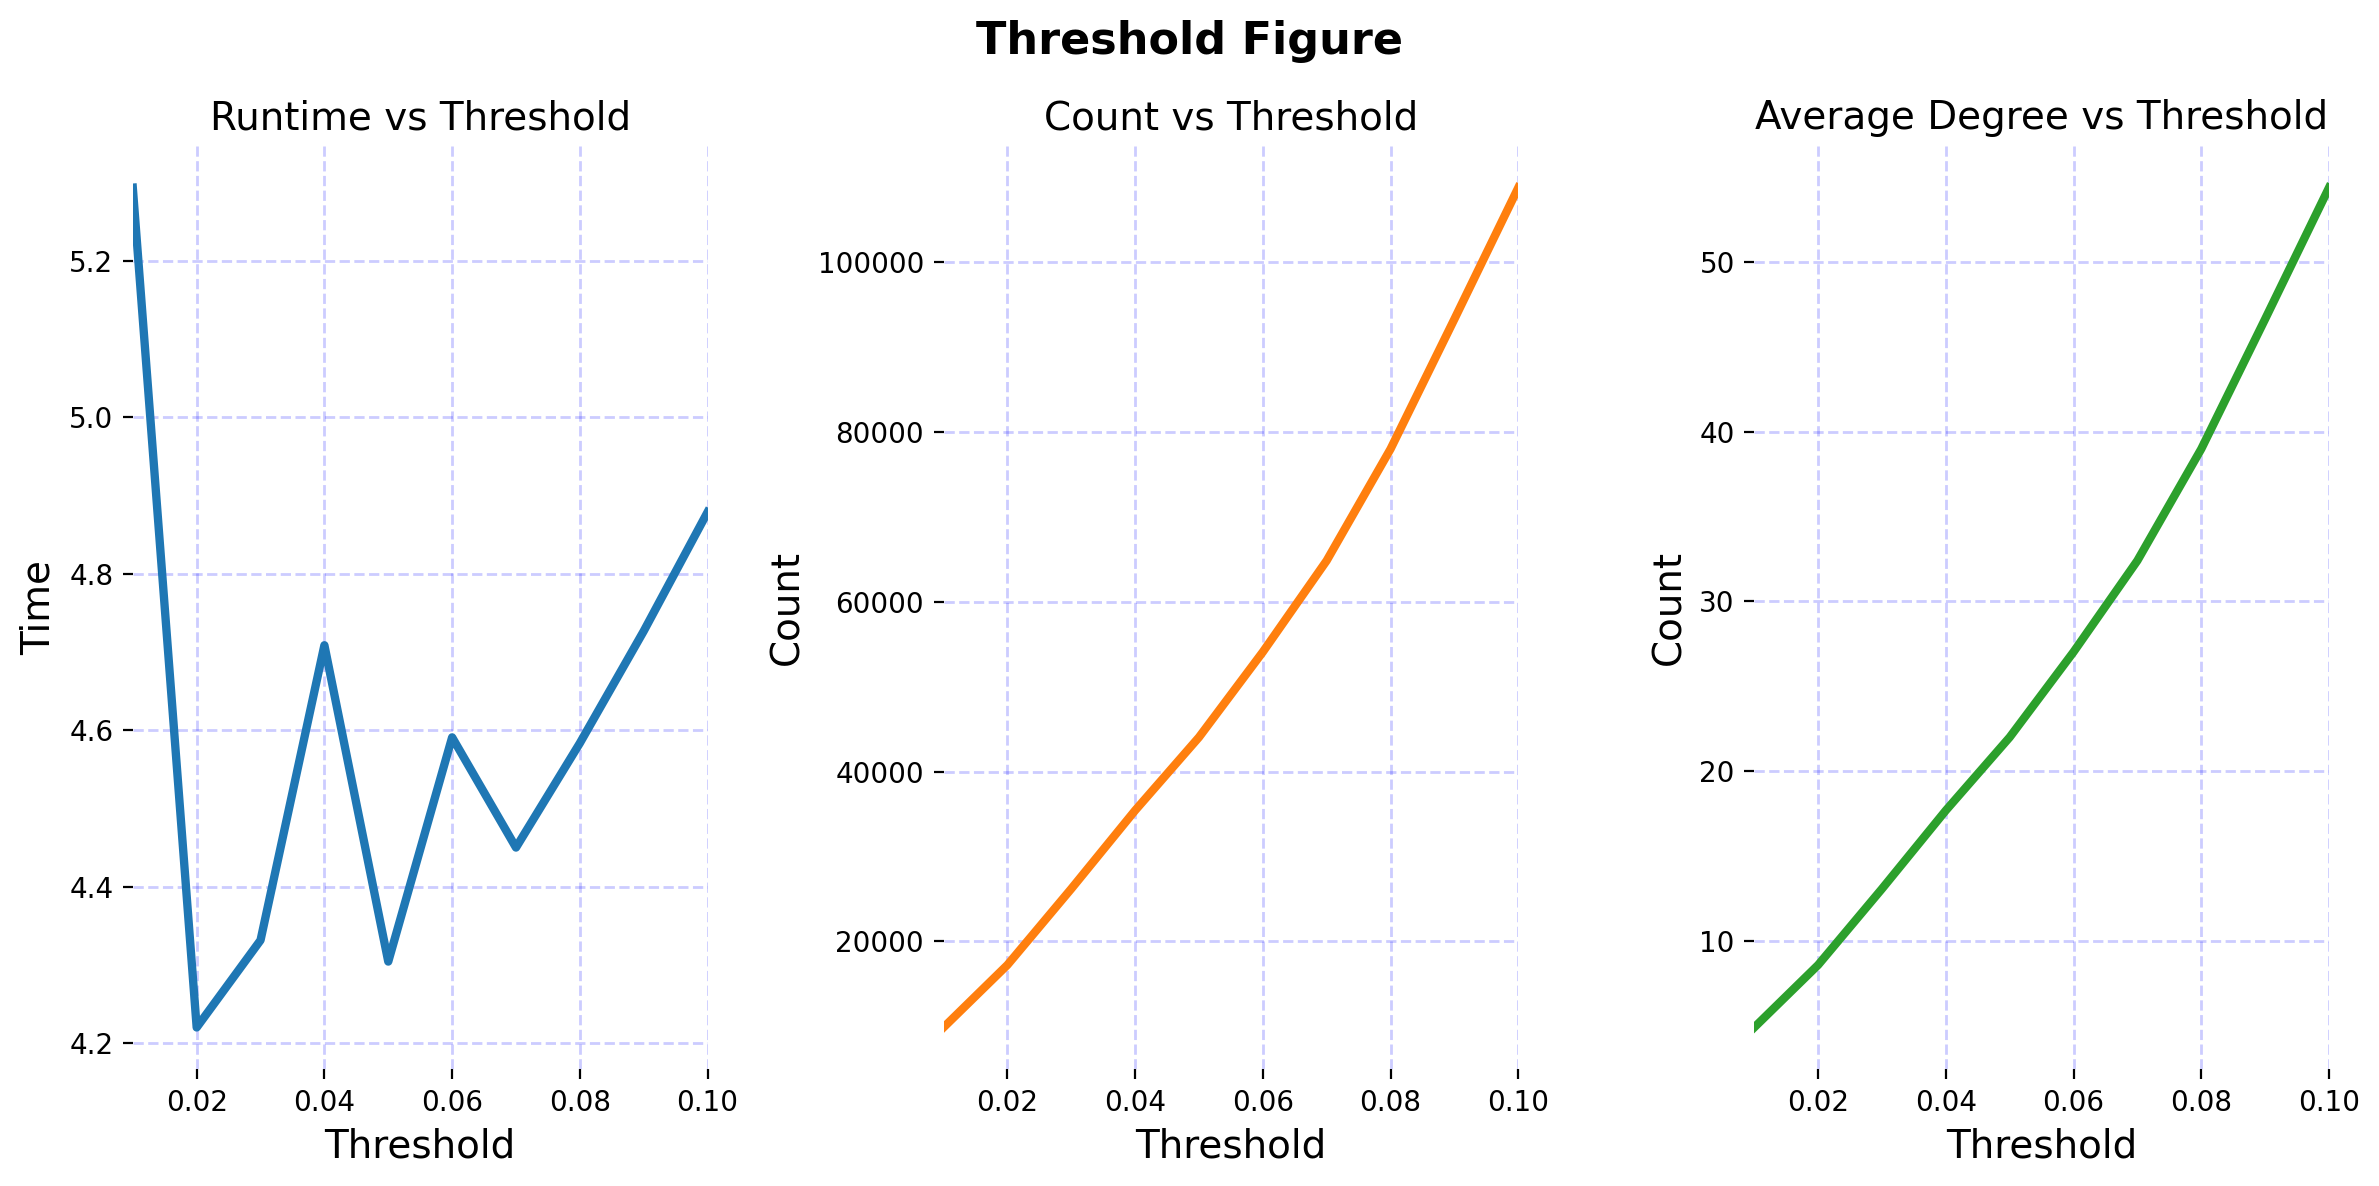

In [18]:
# Plot threshold values
plot_threshold_values(data_v2, transformed_df)

In [19]:
# Save data
folder_path = "../../experiments"
file_name = "lsh-timing_v2.json"
save_data_to_folder(data_v2, folder_path, file_name)

Data saved to ../../experiments/lsh-timing_v2.json


### Recreate Approximate Similarity Join with updated Threshold value

In [20]:
# Perform an approximate similarity join with itself
threshold = 0.02
approx_sim_df = brpLSHModel.approxSimilarityJoin(
    transformed_df, transformed_df, threshold, distCol="EuclideanDistance"
)

## Collaborative Filtering
> **Documentation:** [ALS API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html?highlight=als#pyspark.ml.recommendation.ALS)

In [21]:
# Neighbors of source=datasetA.species_id, destination=datasetB.species_id
# Use ALS collaborative filtering
# Take two columns, groupby(source, destination), count
# Feed that to model
# Play with top 50 species

from pyspark.ml.recommendation import ALS

neighbors_df = (
    approx_sim_df.groupBy(
        F.col("datasetA.species_id").alias("src"),
        F.col("datasetB.species_id").alias("dst"),
    )
    .count()
    .where("src <> dst")
)
neighbors_df.show()

# ALS
als = ALS(
    maxIter=20,
    implicitPrefs=False,
    userCol="src",
    itemCol="dst",
    ratingCol="count",
)
model = als.fit(neighbors_df)

+-------+-------+-----+
|    src|    dst|count|
+-------+-------+-----+
|1397279|1397430|   64|
|1356290|1359979|   15|
|1359231|1356290|  426|
|1393990|1356290|   49|
|1737469|1363800|   37|
|1397430|1722409|  115|
|1393990|1359231|    1|
|1397279|1393990|    1|
|1356290|1393990|   49|
|1722409|1359231|  223|
|1363800|1737469|   37|
|1359979|1397279|   42|
|1397430|1398631|   59|
|1359979|1356290|   15|
|1737469|1398631|   95|
|1359231|1722409|  223|
|1393990|1722409|   89|
|1397279|1737469|   31|
|1397430|1356290|   27|
|1398631|1722409|   57|
+-------+-------+-----+
only showing top 20 rows



In [22]:
neighbors_df.describe().show()

+-------+------------------+------------------+------------------+
|summary|               src|               dst|             count|
+-------+------------------+------------------+------------------+
|  count|                86|                86|                86|
|   mean|1452358.7441860465|1452358.7441860465| 79.86046511627907|
| stddev|144654.97329180024|144654.97329180018|145.31063381926867|
|    min|           1356290|           1356290|                 1|
|    max|           1737469|           1737469|               893|
+-------+------------------+------------------+------------------+



In [23]:
# Get dataframe
transform_als = model.transform(neighbors_df)
transform_als.show()

+-------+-------+-----+----------+
|    src|    dst|count|prediction|
+-------+-------+-----+----------+
|1397279|1397430|   64| 63.899075|
|1356290|1359979|   15|  14.99535|
|1359231|1356290|  426|  425.9668|
|1393990|1356290|   49|  48.99675|
|1737469|1363800|   37|  37.17715|
|1397430|1722409|  115|114.988716|
|1393990|1359231|    1| 1.0343189|
|1397279|1393990|    1| 1.4284122|
|1356290|1393990|   49| 48.811783|
|1722409|1359231|  223| 223.08633|
|1363800|1737469|   37|  36.96559|
|1359979|1397279|   42| 41.908745|
|1397430|1398631|   59|  59.07375|
|1359979|1356290|   15|15.0081005|
|1737469|1398631|   95| 94.458405|
|1359231|1722409|  223|  222.9552|
|1393990|1722409|   89|  88.99355|
|1397279|1737469|   31| 30.930964|
|1397430|1356290|   27| 27.005306|
|1398631|1722409|   57| 57.003113|
+-------+-------+-----+----------+
only showing top 20 rows



In [24]:
# Get recommendations
recs_df = model.recommendForAllUsers(10)
recs_df.show(truncate=80)
recs_df.printSchema()

+-------+--------------------------------------------------------------------------------+
|    src|                                                                 recommendations|
+-------+--------------------------------------------------------------------------------+
|1363800|[{1356290, 121.98957}, {1722409, 70.98314}, {1393990, 41.829456}, {1737469, 3...|
|1397430|[{1359979, 152.80153}, {1722409, 114.988716}, {1737469, 109.98141}, {1393990,...|
|1356290|[{1722409, 892.94415}, {1359231, 426.13113}, {1363800, 121.647644}, {1356290,...|
|1393990|[{1722409, 88.99354}, {1397430, 80.13671}, {1398631, 67.670906}, {1737469, 55...|
|1398631|[{1737469, 94.766365}, {1359979, 76.151054}, {1393990, 67.80913}, {1397430, 5...|
|1359231|[{1356290, 425.9668}, {1722409, 222.95518}, {1359231, 82.104576}, {1363800, 8...|
|1359979|[{1397430, 152.74373}, {1398631, 76.22527}, {1737469, 66.95674}, {1722409, 51...|
|1737469|[{1397430, 110.14604}, {1398631, 94.458405}, {1359979, 67.04102}, {1393990, 5...|

In [25]:
# take some number of K nearest neighbors (100)
# importance sampling using np.choice()
# 5% of images choose randomly
# for every species generate a number of collages (3x3, 5x5, 8x8)
# the images are chosen from importance sampling from the recommendation system
# choose random images that are not in the model
# another option is to build collages all with the same species